In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 26.3 MB/s 
     |████████████████████████████████| 1.6 MB 61.5 MB/s 


In [3]:
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
df_train = pd.read_csv('/content/drive/MyDrive/Redes Neurais/Github/Redes-Neurais/Titanic/train_tratado.csv')

In [10]:
train = df_train.drop(columns = ['Transported'])
y = df_train['Transported']

### Normalizar

transformer = Normalizer().fit(train) 
transformer
train=transformer.transform(train)


#Splitar em treinamento e teste

x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.3)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4624, 27)
(4624,)
(1982, 27)
(1982,)


###Estrutura da rede

In [20]:
def model_builder(hp):
  model = Sequential() 
  hp_units = hp.Int('units', min_value=256, max_value=1600, step=256)
  #model.add(Dense(units=hp_units, activation='elu', input_dim=train.shape[1]))
  #l2_units = hp.Float('l2', 0.01, 0.05, step=0.01)
  #model.add(Dense(units=256, activation='relu', input_dim=train.shape[1], kernel_regularizer=regularizers.L2(l2=l2_units)))
  model.add(Dense(units=hp_units, activation='relu', input_dim=train.shape[1]))
  model.add(Dense(units=hp_units, activation='relu', input_dim=train.shape[1]))
  model.add(Dense(units=hp_units, activation='relu', input_dim=train.shape[1]))
  model.add(Dense(units=hp_units, activation='relu', input_dim=train.shape[1]))
  
  #drop_units = hp.Float('dropout', 0, 0.8, step=0.1, default=0.5)
  #model.add(Dropout(drop_units))
  model.add(Dense(1, activation='sigmoid')) 

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  opt = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) 
  
  return model

In [18]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=10,
                     directory='my_dir_13',
                     project_name='intro_to_kt')

In [23]:
tuner = kt.BayesianOptimization(model_builder,
                     max_trials =15,
                     objective='val_accuracy',
                     directory='my_dir_16')

In [24]:
tuner.search(x_train, y_train, epochs=30, validation_data=(x_test, y_test))

Trial 15 Complete [00h 00m 24s]
val_accuracy: 0.7865791916847229

Best val_accuracy So Far: 0.788092851638794
Total elapsed time: 00h 29m 09s


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. Dropout: {best_hps.get('dropout')}
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 64 and the optimal learning rate for the optimizer
is 0.01. Dropout: 0.4



In [ ]:
tuner.get_best_models()[0]

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
166/166 [==============================] - 2s 5ms/step - loss: 0.5341 - accuracy: 0.7744 - val_loss: 0.4995 - val_accuracy: 0.7920
Epoch 2/100
166/166 [==============================] - 1s 4ms/step - loss: 0.5127 - accuracy: 0.7875 - val_loss: 0.4742 - val_accuracy: 0.8003
Epoch 3/100
166/166 [==============================] - 1s 4ms/step - loss: 0.5024 - accuracy: 0.7850 - val_loss: 0.4825 - val_accuracy: 0.8033
Epoch 4/100
166/166 [==============================] - 1s 4ms/step - loss: 0.4948 - accuracy: 0.7899 - val_loss: 0.4819 - val_accuracy: 0.8101
Epoch 5/100
166/166 [==============================] - 1s 4ms/step - loss: 0.4868 - accuracy: 0.7880 - val_loss: 0.4410 - val_accuracy: 0.8064
Epoch 6/100
166/166 [==============================] - 1s 4ms/step - loss: 0.4863 - accuracy: 0.7892 - val_loss: 0.4893 - val_accuracy: 0.8071
Epoch 7/100
166/166 [==============================] - 1s 4ms/step - loss: 0.4846 - accuracy: 0.7850 - val_loss: 0.5058 - val_accuracy: 0.8018

[]

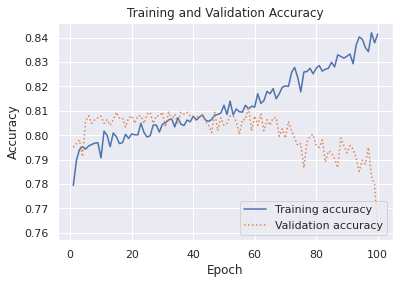

In [ ]:
sns.set()
 
acc = history.history['accuracy']
val = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

[]

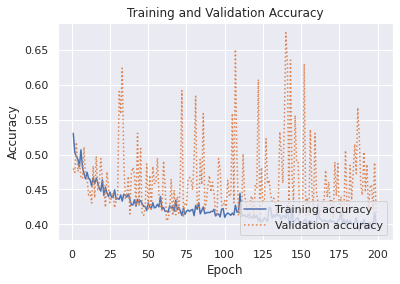

In [ ]:
sns.set()
 
acc = history.history['loss']
val = history.history['val_loss']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()